# All the includes for the NoteBook

In [40]:
import IO
import ROOT
import torch
from torch_geometric.data import Data, DataLoader 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import dgl
import PyGeometric_Function as PF
import Trivial_Functions as TF
import Plotting_Functions as PLT

# Collect the data in a dictionary format

In [42]:
f = ROOT.TFile("Data/W_to_lepton.root")
Particle_Maps = IO.ReadRootFile(f)
IO.VerifyProcess(Particle_Maps, 0)
Map = IO.CreateFeatureDictionary(Particle_Maps)

# Create the Graph we wish to train on 

In [43]:
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2], [1, 2, 0, 2, 0, 1]], dtype = torch.long)

# Populate the Graph with Edge and Node Feature Data

In [4]:
data_list = []

for i in range(len(Map["WPx"])):
    # Create the tensors of the individual features
    # Node features
    W_Node = [Map["WPx"][i], Map["WPy"][i], Map["WPz"][i], Map["WE"][i], Map["WM"][i], Map["WC"][i]]

    e_Node = [Map["ePx"][i], Map["ePy"][i], Map["ePz"][i], Map["eE"][i], Map["eM"][i], Map["eC"][i]]
    ve_Node = [Map["vePx"][i], Map["vePy"][i], Map["vePz"][i], Map["veE"][i], Map["veM"][i], Map["veC"][i]]
    
    # Edge features 
    W_e = [Map["W_e"][i], Map["W_e_C"][i]]
    W_ve = [Map["W_ve"][i], Map["W_ve_C"][i]]
    e_ve = [Map["e_ve"][i], Map["e_ve_C"][i]]
    
    Node_feat = torch.tensor([W_Node, e_Node, ve_Node], dtype = torch.float)
    Edge_feat = torch.tensor([W_e, W_ve, W_e, e_ve, W_ve, e_ve], dtype = torch.float) 

    data = Data(x = Node_feat, edge_index = edge_index, edge_attr = Edge_feat)
    data_list.append(data)

    
loader = DataLoader(data_list)

# Give DGL the Graph Structure with Data

In [30]:
# nxg = nx.DiGraph()
# nxg.add_node(0, id = 0, n1 = [Map["WPx"][0], Map["WPy"][0], Map["WPz"][0], Map["WE"][0], Map["WM"][0], Map["WC"][0]])
# nxg.add_node(1, id = 1, n1 = [Map["ePx"][0], Map["ePy"][0], Map["ePz"][0], Map["eE"][0], Map["eM"][0], Map["eC"][0]])
# nxg.add_node(2, id = 2, n1 = [Map["vePx"][0], Map["vePy"][0], Map["vePz"][0], Map["veE"][0], Map["veM"][0], Map["veC"][0]])
# nxg.add_edge(0, 1, id=0, e1 = [Map["W_e"][0], Map["W_e_C"][0]])
# nxg.add_edge(0, 2, id=0, e1 = [Map["W_ve"][0], Map["W_ve_C"][0]])
# nxg.add_edge(1, 0, id=1, e1 = [Map["W_e"][0], Map["W_e_C"][0]])
# nxg.add_edge(1, 2, id=1, e1 = [Map["e_ve"][0], Map["e_ve_C"][0]])
# nxg.add_edge(2, 0, id=2, e1 = [Map["W_ve"][0], Map["W_ve_C"][0]])
# nxg.add_edge(2, 1, id=2, e1 = [Map["e_ve"][0], Map["e_ve_C"][0]])
# G = dgl.from_networkx(nxg, edge_attrs = ["e1"], node_attrs = ["n1"])

nxg = nx.DiGraph()
nxg.add_node(0, id = 0)
nxg.add_node(1, id = 1)
nxg.add_node(2, id = 2)
nxg.add_edge(0, 1, id=0)
nxg.add_edge(0, 2, id=0)
nxg.add_edge(1, 0, id=1)
nxg.add_edge(1, 2, id=1)
nxg.add_edge(2, 0, id=2)
nxg.add_edge(2, 1, id=2)

G = dgl.from_networkx(nxg)
G.ndata["n1"] = torch.tensor([Map["WC"], Map["eC"], Map["veC"]], dtype = torch.float) 

In [35]:
node_features = G.ndata["n1"]
n_features = node_features.size(1)

In [36]:
k = 1

In [37]:
model = PF.Model(n_features, n_features, 1)
opt = torch.optim.Adam(model.parameters())

for epoch in range(100):
    negative_graph = PF.construct_negative_graph(G, k)
    pos_score, neg_score = model(G, negative_graph, node_features)
    loss = PF.compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()

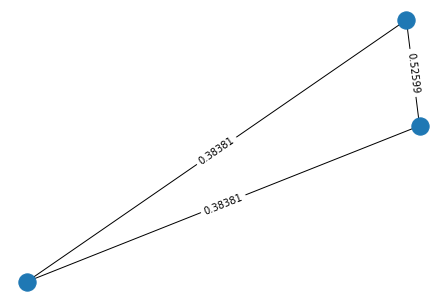

In [38]:
node_embeddings = model.sage(G, node_features)

Node_1_2 = TF.CalculateLinkProbability(node_embeddings[0], node_embeddings[1])
Node_1_3 = TF.CalculateLinkProbability(node_embeddings[0], node_embeddings[2])
Node_2_1 = TF.CalculateLinkProbability(node_embeddings[1], node_embeddings[0])
Node_2_3 = TF.CalculateLinkProbability(node_embeddings[1], node_embeddings[2])
Node_3_1 = TF.CalculateLinkProbability(node_embeddings[2], node_embeddings[0])
Node_3_2 = TF.CalculateLinkProbability(node_embeddings[2], node_embeddings[1])


edge_index = torch.tensor([[0, 0, 1, 1, 2, 2], [1, 2, 0, 2, 0, 1]], dtype = torch.long)
edge_weights = [Node_1_2, Node_1_3, Node_2_1, Node_2_3, Node_3_1, Node_3_2];

PLT.CreateGraphOutput(edge_index, edge_weights)


